In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy import Point
from geopy.geocoders import Nominatim
from geopy import distance
from numpy import arange
from pandas import DataFrame
from skopt import gp_minimize
import skopt.plots as skplt
from numba import njit

In [2]:
data = pd.read_csv('2013_Events.csv')
data['Event start date'] = pd.to_datetime(data['Event start date'])
data = data.sort_values(by = 'Event start date')
data = data.loc[data['Event start date'] > '2013-11-15']
# data = data[['Event start date', 'Number of protesters', 'Location']]
data.head()

,ID,Event start date,One day?,Event end date,Day of the week,Action type,Action,Actor-structure,Actor-form,Actor-ideology,...,Public transportation,Number of protesters,Number of civilians arrested,Number of civilians injured,Number of civilians killed,Property damage,State forces involved in the conflict,Number of state forces injured,Number of state forces killed,Dubious event
3312,KR13111601,2013-11-16,approximate,11/16/2013,Sat,other repression,harass,state forces,NaN,NaN,...,NaN,NaN,0.0,0.0,0,N,1.0,0.0,0,N
1010,DN13111602,2013-11-16,approximate,11/16/2013,Sat,protest,graffiti,skinheads,NaN,rightists,...,NaN,NaN,0.0,0.0,0,Y,0.0,0.0,0,N
1011,DN13111603,2013-11-16,1,11/16/2013,Sat,negative response,criminal case,law-enforcement,NaN,NaN,...,NaN,NaN,0.0,0.0,0,N,0.0,0.0,0,N
6232,VN13111601,2013-11-16,1,11/16/2013,Sat,protest,rally,neighborhood,NaN,NaN,...,NaN,99.0,0.0,0.0,0,N,NaN,0.0,0,N
5095,OD13111602,2013-11-16,1,11/16/2013,Sat,protest,demonstration/march,NaN,NGO,Russian nationalists,...,NaN,29.0,0.0,0.0,0,N,NaN,0.0,0,N


In [3]:
data['Number of events'] = 0
data = data.groupby(['Event start date', 'Location', 'Oblast'], as_index=False).aggregate({'Number of events': 'size', 'Number of protesters': 'sum'})

In [4]:
data['Location'].nunique()

224

In [5]:
data.tail()

,Event start date,Location,Oblast,Number of events,Number of protesters
1048,2013-12-31,Kryvyi Rih,Dnipropetrovsk,1,0.0
1049,2013-12-31,Marinka District,Donetsk,1,0.0
1050,2013-12-31,Poltava,Poltava,1,0.0
1051,2013-12-31,Rivne,Rivne,2,101.0
1052,2013-12-31,Ternopil,Ternopil,3,0.0


In [6]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
#
# print(data)

In [7]:
geolocator = Nominatim(user_agent="Your_Name")



In [8]:
coord_dict = {}

In [12]:
def get_coords(name):
    # print('Getting coords for: ' + name)
    if name in coord_dict:
        return coord_dict[name]
    else:
        # print('Getting coords for: ' + name)
        coords = geolocator.geocode(name)
        if coords:
            coord_dict[name] = Point([coords.longitude, coords.latitude])
            return coord_dict[name]
        else:
            # print('No Data')
            return None

In [13]:
# Construct an array containing the distances between all 224 locations

result = [get_coords(x + ', ' + y) for x, y in zip(data['Oblast'], data['Location'])]

In [11]:
%store -r coord_dict

In [14]:
# only 174 out of 224 could find coords, need to come back to this
print(len(coord_dict))

174


In [15]:
result = [x + ', ' + y for x, y in zip(data['Oblast'], data['Location'])]
# data.insert(5, 'Location String', result)

In [16]:
# 226 locations
print(len(set(result)))

226


In [17]:
# Remove entries for which we can't find coordinates

for index, row in data.iterrows():
    if row['Oblast'] + ', ' + row['Location'] not in coord_dict:
        data.drop(index, inplace=True)

In [18]:
# Create array containing distances between points

distance_dict = {}

In [19]:
for key1 in coord_dict:
    key1_dict = {}
    for key2 in coord_dict:
        if key1 != key2:
            key1_dict[key2] = distance.distance(coord_dict[key1], coord_dict[key2]).km
        else:
            key1_dict[key2] = 0

    distance_dict[key1] = key1_dict

In [20]:
print(distance_dict['Kyiv, Kyiv']['Kyiv, Kyiv'])

0


In [22]:
data.head()

,Event start date,Location,Oblast,Number of events,Number of protesters
0,2013-11-16,Chernihiv,Chernihiv,4,7.0
1,2013-11-16,Donetsk,Donetsk,3,18.0
2,2013-11-16,Ivano-Frankivsk,Ivano-Frankivsk,1,0.0
3,2013-11-16,Kirovohrad,Kirovohrad,1,0.0
4,2013-11-16,Kyiv,Kyiv,3,99.0


In [23]:
data.loc[data['Location'] == 'Kyiv, Kyiv']


,Event start date,Location,Oblast,Number of events,Number of protesters


In [24]:
data.loc[data['Event start date'] == '2013-11-17']

,Event start date,Location,Oblast,Number of events,Number of protesters
14,2013-11-17,Kirovohrad,Kirovohrad,2,0.0
15,2013-11-17,Lviv,Lviv,2,999.0
16,2013-11-17,Merefa,Kharkiv,2,0.0
17,2013-11-17,Odesa,Odesa,2,14.0
18,2013-11-17,Rivne,Rivne,1,149.0
19,2013-11-17,Sivka-Voinylivska village,Ivano-Frankivsk,1,35.0
20,2013-11-17,Stetskivka village,Sumy,1,27.0
21,2013-11-17,Sumy,Sumy,2,9.0
22,2013-11-17,Zaporizhzhia,Zaporizhzhia,1,5.0


In [25]:
data['Location'] = data['Oblast'] + ', ' + data['Location']

In [26]:
data = data.drop(columns=['Oblast'])
data.head()

,Event start date,Location,Number of events,Number of protesters
0,2013-11-16,"Chernihiv, Chernihiv",4,7.0
1,2013-11-16,"Donetsk, Donetsk",3,18.0
2,2013-11-16,"Ivano-Frankivsk, Ivano-Frankivsk",1,0.0
3,2013-11-16,"Kirovohrad, Kirovohrad",1,0.0
4,2013-11-16,"Kyiv, Kyiv",3,99.0


In [27]:
data['Location'].nunique()


174

In [28]:
len(data)

969

In [29]:
len(data.loc[data['Location'] == 'Kyiv, Kyiv'])

44

In [30]:
data['Event start date'].nunique()

46

In [31]:
def createSimulationDF(df):
    data1 = df.copy()
    data1['Event start date'] = pd.to_numeric(data['Event start date'])
    data1['Event start date'] = ((data1['Event start date']-1384560000000000000)/86400000000000).astype(int)
    # data1['N0'] = n
    # data1['simulated'] = 0
    # data1['simulated'][0] = 1
    # data1 = data1[['Event start date', 'Number of events', 'Number of protesters', 'N0', 'simulated', 'Location']]
    return data1

In [32]:
# Handle 'empty days'?
createSimulationDF(data).tail()

,Event start date,Location,Number of events,Number of protesters
1047,45,"Kharkiv, Kharkiv",2,58.0
1048,45,"Dnipropetrovsk, Kryvyi Rih",1,0.0
1050,45,"Poltava, Poltava",1,0.0
1051,45,"Rivne, Rivne",2,101.0
1052,45,"Ternopil, Ternopil",3,0.0


In [33]:
def simulaterHelper(x, args):
    arr = x[-1]
    d = -x[:-1,0] + arr[0]
    psum = x[:-1,1] * (np.exp((-(d-1))/args[0][1]) - np.exp(-d/args[0][1]))
    # arr[4] = np.random.poisson(arr[3] + args[0][0]*psum.sum(), 1)[0]
    # if arr[4] == 0:
    #     arr[4] = 1
    arr[4] = arr[3] + args[0][0]*psum.sum()
    # arr[4] = psum.sum()
    # arr[4] = d[-1]
    return arr

In [34]:
def createSimDF(n):
    df = pd.DataFrame(index=range(0,46),columns=['Event start date', 'N0', 'simulated'])
    df['N0'] = n
    df['simulated'] = 0.0
    df['simulated'][0] = n
    df['Event start date'] = df.index
    return df

In [35]:
simDF = createSimDF(3.25)
simDF.tail()

/Users/lucaswebb/.pyenv/versions/pandas-virtual-env-3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Event start date,N0,simulated
41,41,3.25,0.0
42,42,3.25,0.0
43,43,3.25,0.0
44,44,3.25,0.0
45,45,3.25,0.0


In [36]:
simDFHelper = createSimulationDF(data)

In [37]:
simDFHelper.shape[0]

969

In [38]:
pd.to_numeric(pd.to_datetime(['2013-12-31']))

Int64Index([1388448000000000000], dtype='int64')

In [39]:
((1388448000000000000-1384560000000000000)/86400000000000)

45.0

In [40]:
def calculatePSum(i, Texcite, D):
    arr = simDFHelper.loc[simDFHelper['Event start date'] < i]
    psum = 0
    for index, row in arr.iterrows():
        psum += (1/(D * distance_dict['Kyiv, Kyiv'][row['Location']] + 1)) * (row['Number of events']*(np.exp((-(i-row['Event start date']-1))/Texcite) - np.exp(-(i-row['Event start date'])/Texcite)))
        # psum += (np.exp((-(i-row['Event start date']-1))/Texcite) - np.exp(-(i-row['Event start date'])/Texcite))
    return psum

In [41]:
def simulate(Nsec, Texcite, D):
    for index, row in simDF.iterrows():
        if index != 0:
            simDF['simulated'][index] = simDF['N0'][index] + Nsec * calculatePSum(index, Texcite, D)
            # simDF['simulated'][index] = calculatePSum(index, Texcite, D)
    return simDF

In [42]:
%%time
sim = simulate(0.1, 1, 0)

/Users/lucaswebb/.pyenv/versions/pandas-virtual-env-3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


CPU times: user 2.46 s, sys: 21.5 ms, total: 2.48 s
Wall time: 2.61 s


In [43]:
sim.head()

,Event start date,N0,simulated
0,0,3.25,3.250000
1,1,3.25,4.514241
2,2,3.25,4.600057
3,3,3.25,4.568415
4,4,3.25,4.872835


In [44]:
groupedData = simDFHelper.loc[simDFHelper['Location'] == 'Kyiv, Kyiv']
groupedData.set_index('Event start date', inplace=True)
df2 = pd.DataFrame({'Event start date':range(0,46), 'Location': 'Kyiv, Kyiv', 'Number of events':0, 'Number of protesters':0})
df2.set_index('Event start date')
df2['Number of events'] = groupedData['Number of events']
df2['Number of protesters'] = groupedData['Number of protesters']
df2= df2.fillna(0)
groupedData = df2

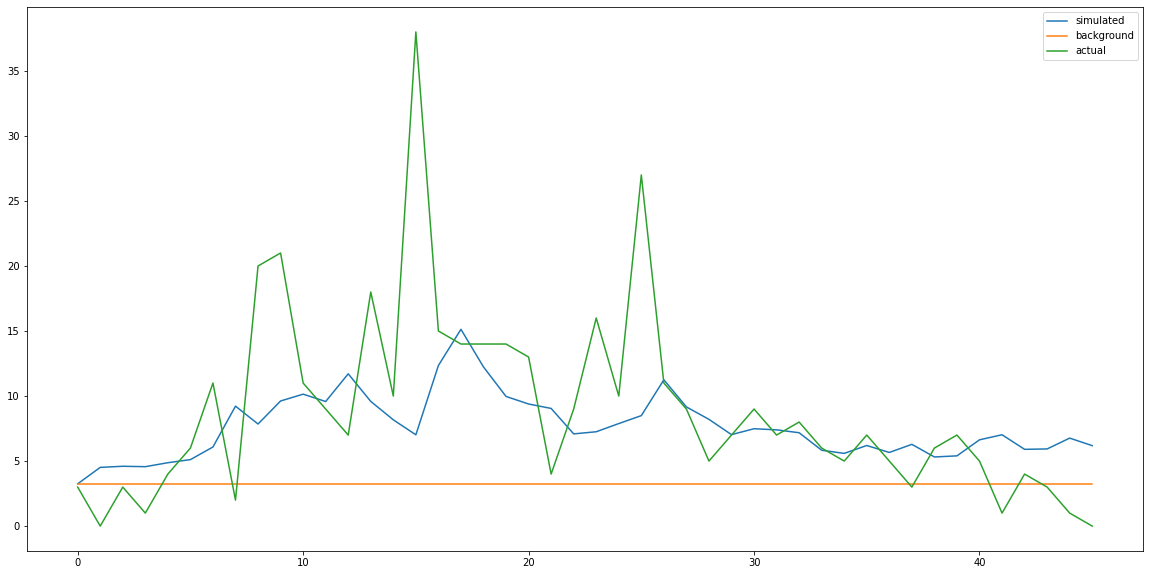

In [45]:
plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

In [46]:
def l2Error(simulated, actual):
    return np.power(actual - simulated, 2).sum()

In [47]:
l2Error(sim['simulated'], groupedData['Number of events'])


2092.6154037894157

In [48]:
pd.options.mode.chained_assignment = None  # default='warn'

In [49]:
# Try fitting this 3 param model with Bayesian optimization based on gaussian process regression from skopt

def funcToMinimize(params):
    sim = simulate(params[0], params[1], params[2])
    return l2Error(sim['simulated'], groupedData['Number of events'])

In [50]:
funcToMinimize([0.6, 8, 1000])

2237.308187218777

In [830]:
res = gp_minimize(funcToMinimize, [(0.0, 1.0), (0.0001, 10), (0.0, 1000.0)], n_calls=30, noise=1e-10, n_initial_points=1, random_state=123)

In [831]:
res.x

[0.6505237250672847, 1.94689871729908, 337.76797585562053]

In [832]:
res.fun
#1828

1828.9562051370358

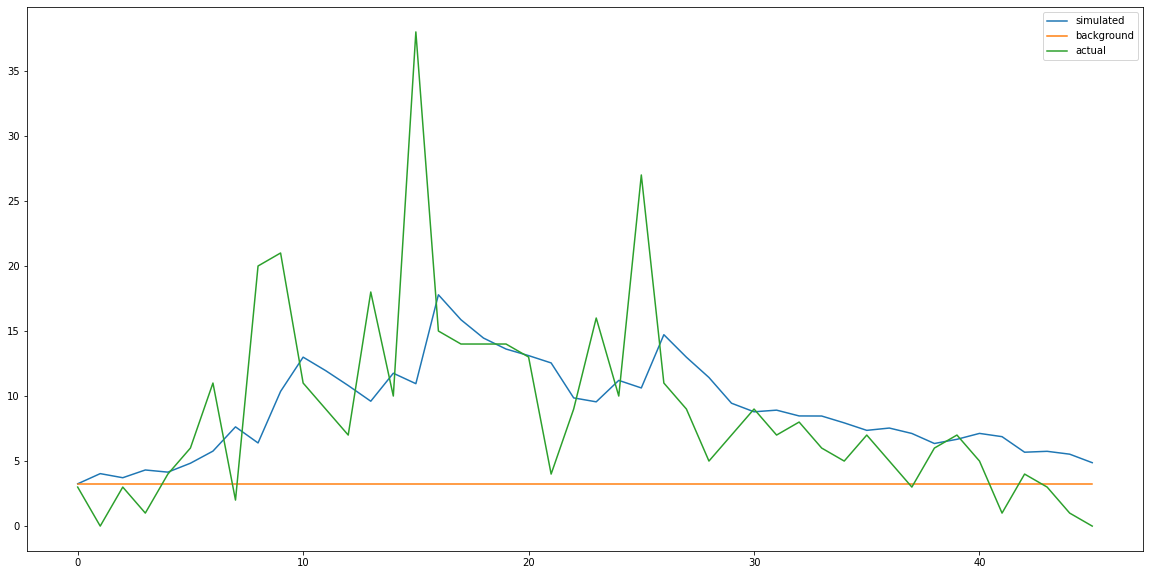

In [833]:
sim = simulate(res.x[0], res.x[1], res.x[2])

plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

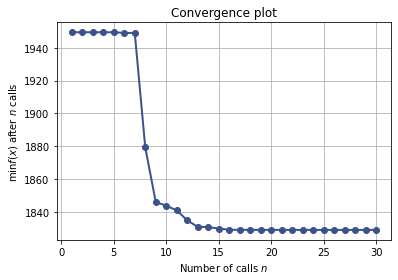

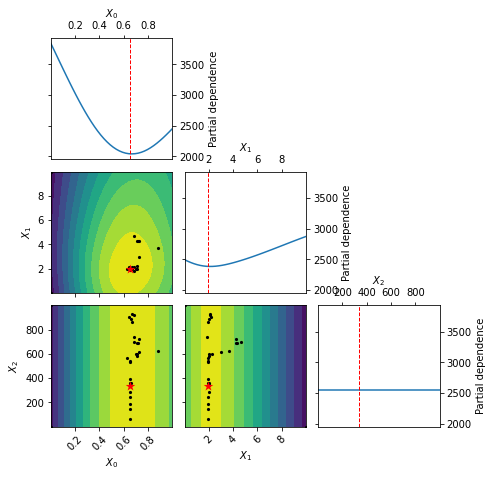

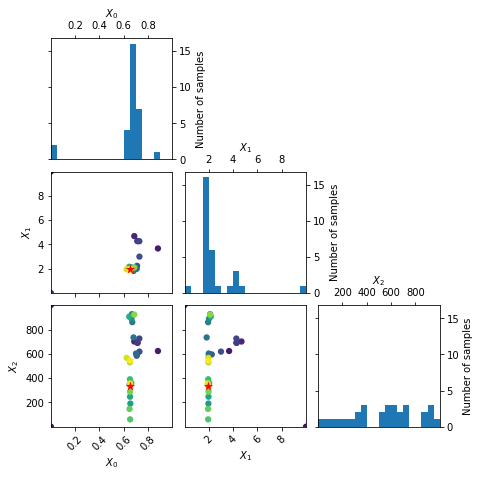

In [834]:
skplt.plot_convergence(res);
skplt.plot_objective(res);
skplt.plot_evaluations(res);

In [51]:
# Try fitting 2 param model with Bayesian optimization based on gaussian process regression from skopt

def funcToMinimize2(params):
    sim = simulate(params[0], params[1], 0)
    return l2Error(sim['simulated'], groupedData['Number of events'])

In [763]:
%%time
res2 = gp_minimize(funcToMinimize2, [(0.0, 1.0), (0.0001, 20.0)], n_calls=25, noise=1e-10, n_initial_points=1, random_state=123)

CPU times: user 1min 47s, sys: 9.3 s, total: 1min 56s
Wall time: 1min 26s


In [736]:
res2.x

[0.14131668724114752, 2.950683366688289]

In [737]:
res2.fun
#1873

1874.0029103673628

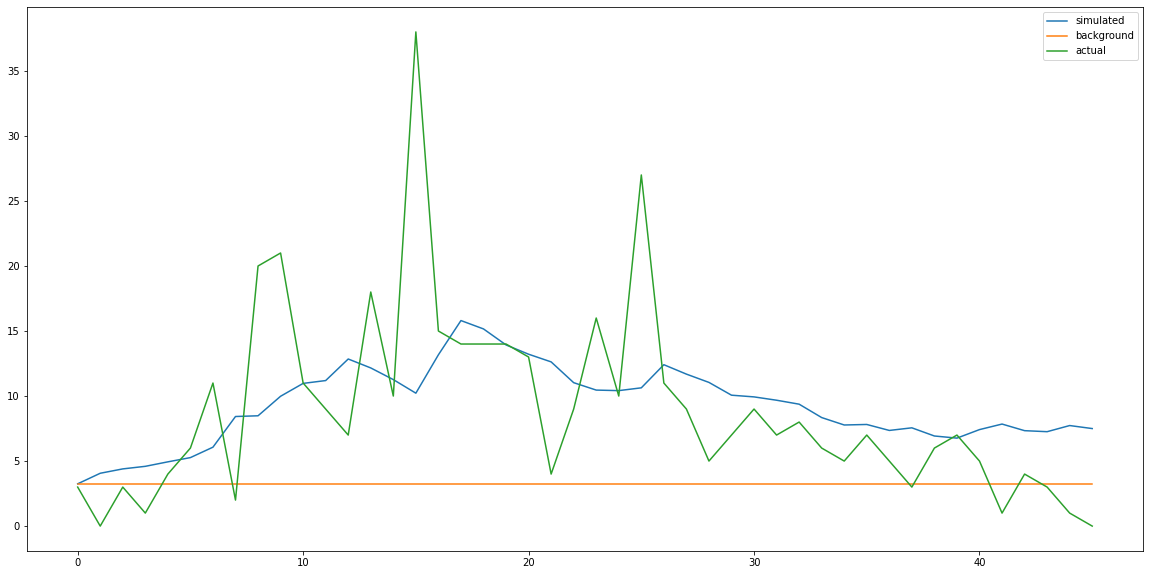

In [738]:
sim = simulate(res2.x[0], res2.x[1], 0)

plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

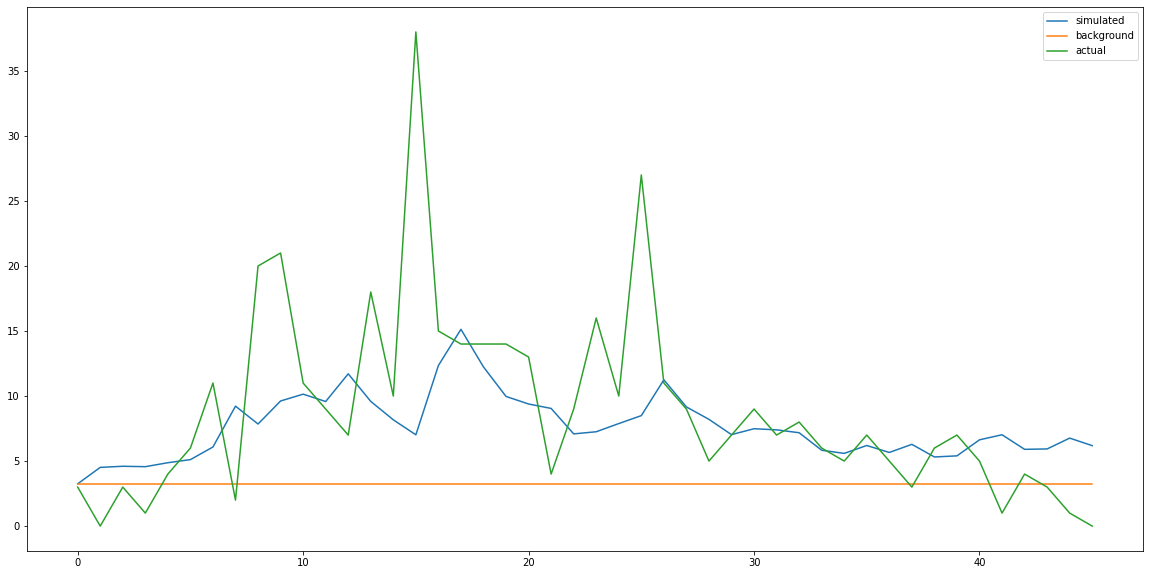

In [668]:
sim = simulate(0.1, 1, 0)

plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

In [669]:
l2Error(sim['simulated'], groupedData['Number of events'])

2092.6154037894157

In [661]:
sim.head()

,Event start date,N0,simulated
0,0,3.25,3.250000
1,1,3.25,4.514241
2,2,3.25,4.600057
3,3,3.25,4.568415
4,4,3.25,4.872835


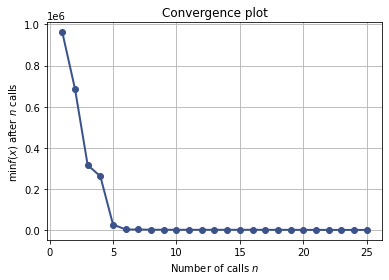

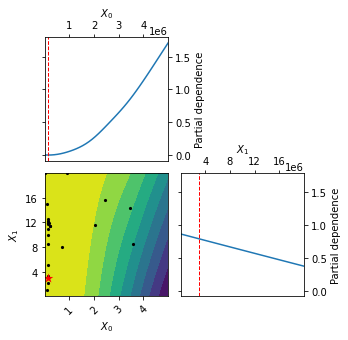

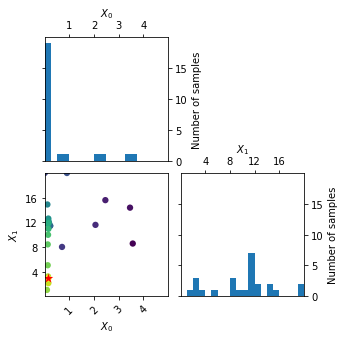

In [741]:
skplt.plot_convergence(res2);
skplt.plot_objective(res2);
skplt.plot_evaluations(res2);

In [52]:
# Use poisson-MLE

def computeLoss(model, actual):
    return (model - (actual * np.log(model))).sum()

In [53]:
def funcToMinimize3(params):
    sim = simulate(params[0], params[1], params[2])
    return computeLoss(sim['simulated'], groupedData['Number of events'])

In [86]:
res3 = gp_minimize(funcToMinimize3, [(0.0, 1.0), (0.0001, 10), (0.0, 2.0)], n_calls=30, noise=1e-10, n_initial_points=1, random_state=123)

In [87]:
res3.x

[0.6303571458233431, 1.7619516508864805, 0.7438456386888782]

In [88]:
res3.fun

-523.7286399699755

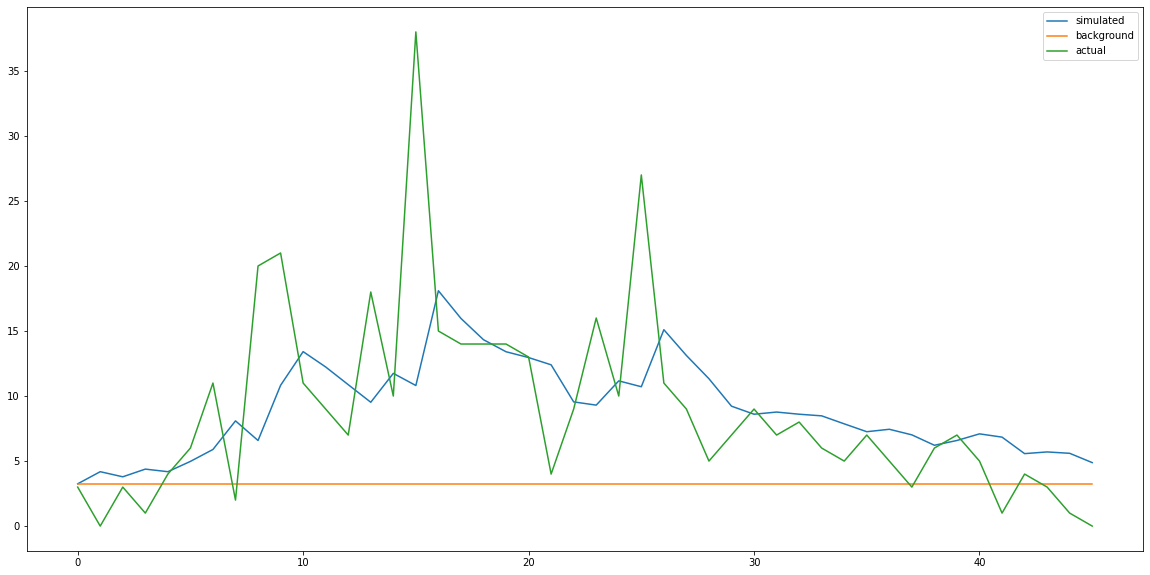

In [89]:
sim = simulate(res3.x[0], res3.x[1], res3.x[2])

plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

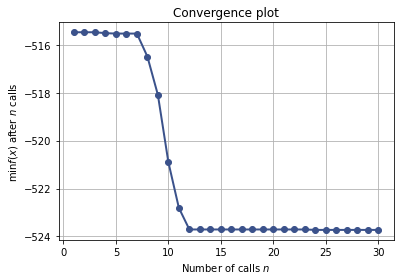

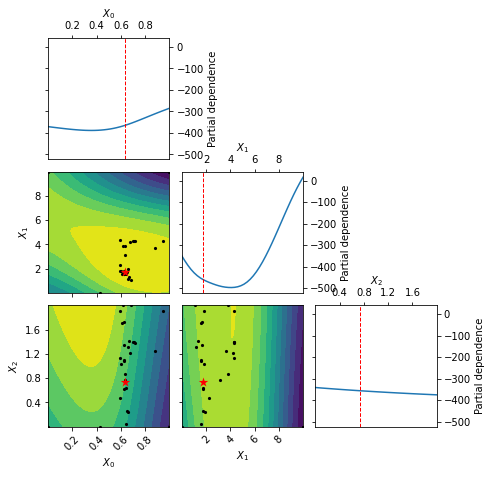

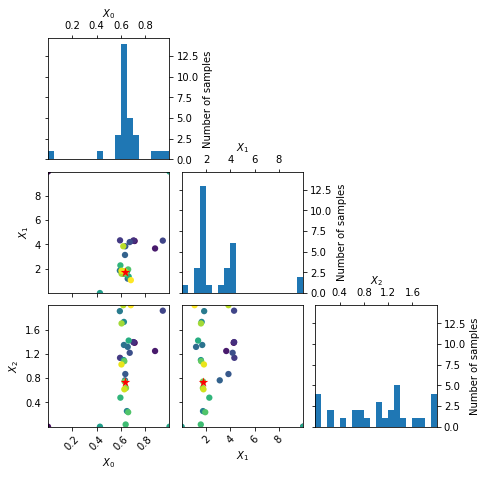

In [90]:
skplt.plot_convergence(res3);
skplt.plot_objective(res3);
skplt.plot_evaluations(res3);

In [54]:
# Distance independent model

def funcToMinimize4(params):
    sim = simulate(params[0], params[1], 0)
    return computeLoss(sim['simulated'], groupedData['Number of events'])

In [60]:
res4 = gp_minimize(funcToMinimize4, [(0.0, 1.0), (0.0001, 10)], n_calls=30, noise=1e-10, n_initial_points=1, random_state=123)

In [61]:
res4.x

[0.13697452854159778, 2.737284686845371]

In [62]:
res4.fun

-519.5393221679773

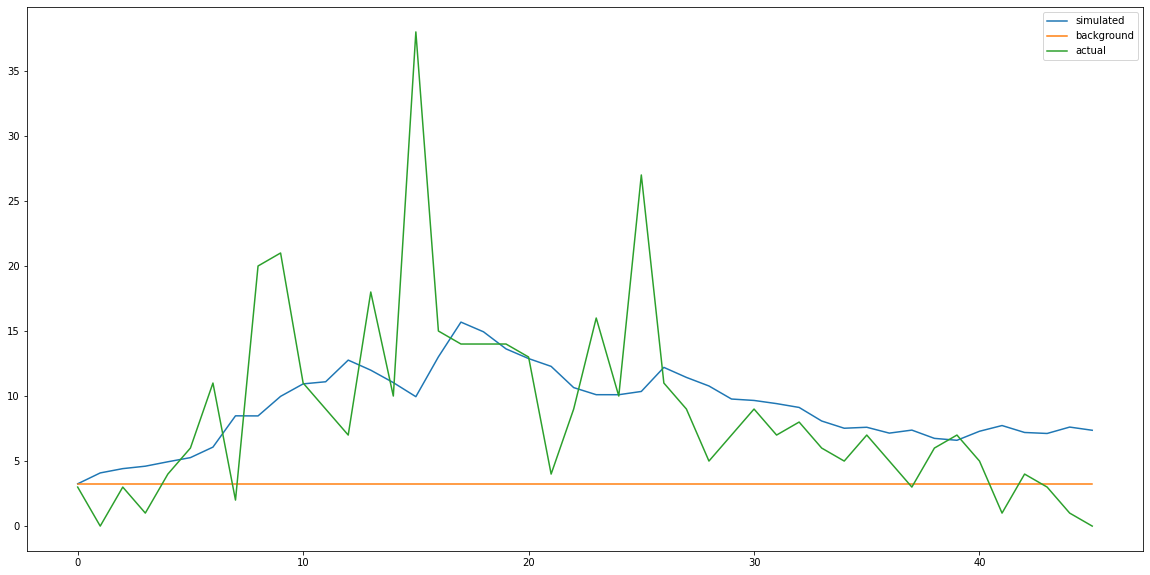

In [63]:
sim = simulate(res4.x[0], res4.x[1], 0)

plt.figure(figsize=(20,10))
plt.plot(sim['simulated'], label='simulated')
plt.plot(sim['N0'], label='background')
plt.plot(groupedData['Number of events'], label='actual')
plt.legend()

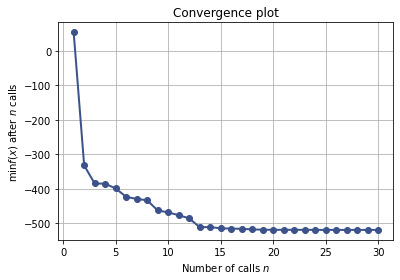

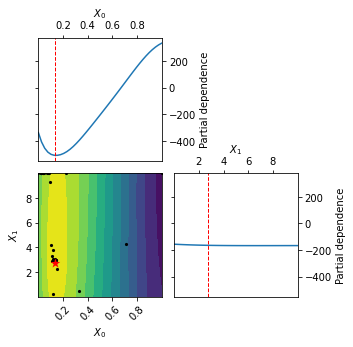

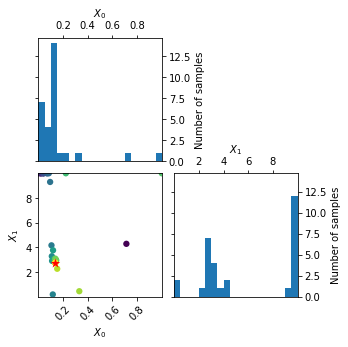

In [65]:
skplt.plot_convergence(res4);
skplt.plot_objective(res4);
skplt.plot_evaluations(res4);

In [80]:
funcToMinimize3([0.658, 1.7258, 0.1])

-521.0329683737716

In [91]:
computeLoss(groupedData['Number of events'], groupedData['Number of events'])

/Users/lucaswebb/pandas/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-607.9294208704014

In [55]:
# Try two parameter distance term

def calculatePSum2(i, Texcite, D, c):
    arr = simDFHelper.loc[simDFHelper['Event start date'] < i]
    psum = 0
    for index, row in arr.iterrows():
        psum += (1/(np.power((D * distance_dict['Kyiv, Kyiv'][row['Location']] + 1), c))) * (row['Number of events']*(np.exp((-(i-row['Event start date']-1))/Texcite) - np.exp(-(i-row['Event start date'])/Texcite)))
    return psum

In [56]:
def simulate2(Nsec, Texcite, D, c):
    for index, row in simDF.iterrows():
        if index != 0:
            simDF['simulated'][index] = simDF['N0'][index] + Nsec * calculatePSum2(index, Texcite, D, c)
    return simDF

In [57]:
def funcToMinimize5(params):
    sim = simulate2(params[0], params[1], params[2], params[3])
    return computeLoss(sim['simulated'], groupedData['Number of events'])

In [112]:
res5 = gp_minimize(funcToMinimize5, [(0.0, 1.0), (0.0001, 10), (0.0, 10.0), (0.0, 2.0)], n_calls=30, noise=1e-10, n_initial_points=1, random_state=123)

In [113]:
res5.x

[0.6738865405452839, 2.0485631777876403, 6.972452033996975, 1.0362364344051334]

In [114]:
res5.fun

-523.568261603221

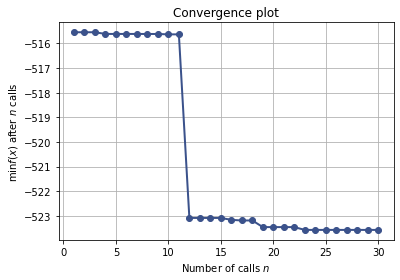

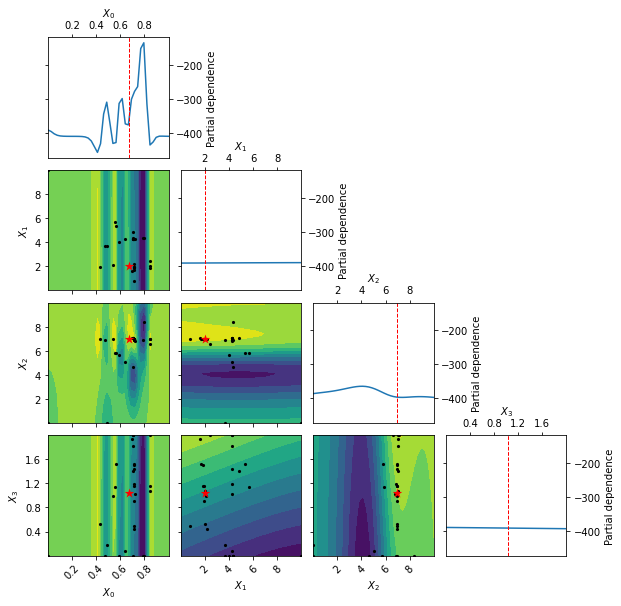

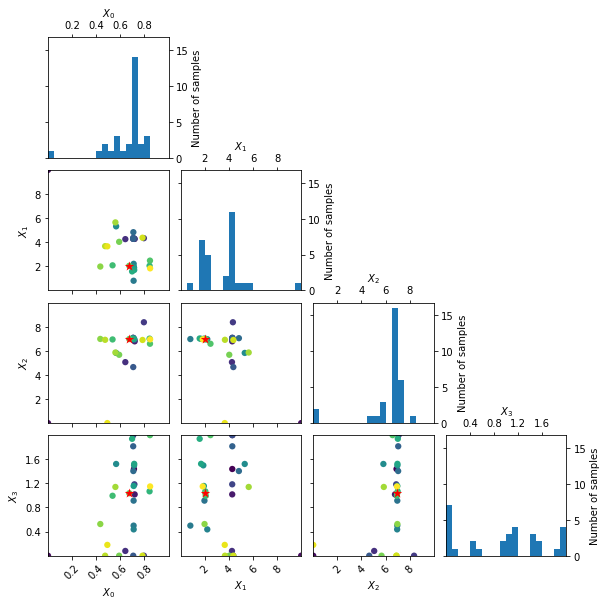

In [115]:
skplt.plot_convergence(res5);
skplt.plot_objective(res5);
skplt.plot_evaluations(res5);

In [ ]:
## wrong doc

# 2 param distance model isn't any better so lets stick to the 1 param distance model
# Now take background as average over entire window and add a scaling param like before
# But first lets try 1 distance param model with 25 params for each nsec

def calculatePSum6(i, Texcite, D):
    arr = simDFHelper.loc[simDFHelper['Event start date'] < i]
    psum = 0
    for index, row in arr.iterrows():
        psum += (1/(D * distance_dict['Kyiv, Kyiv'][row['Location']] + 1)) * (row['Number of events']*(np.exp((-(i-row['Event start date']-1))/Texcite) - np.exp(-(i-row['Event start date'])/Texcite)))
        # psum += (np.exp((-(i-row['Event start date']-1))/Texcite) - np.exp(-(i-row['Event start date'])/Texcite))
    return psum

In [ ]:
def simulate6(Nsec, Texcite, D):
    for index, row in simDF.iterrows():
        if index != 0:
            simDF['simulated'][index] = simDF['N0'][index] + Nsec * calculatePSum(index, Texcite, D)
            # simDF['simulated'][index] = calculatePSum(index, Texcite, D)
    return simDF